# __Transformers 的基本用法：__

In [1]:
!pip install transformers

## __一、使用 pipelines:__

* __情感分类：__

In [14]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

### __管道的内部:__

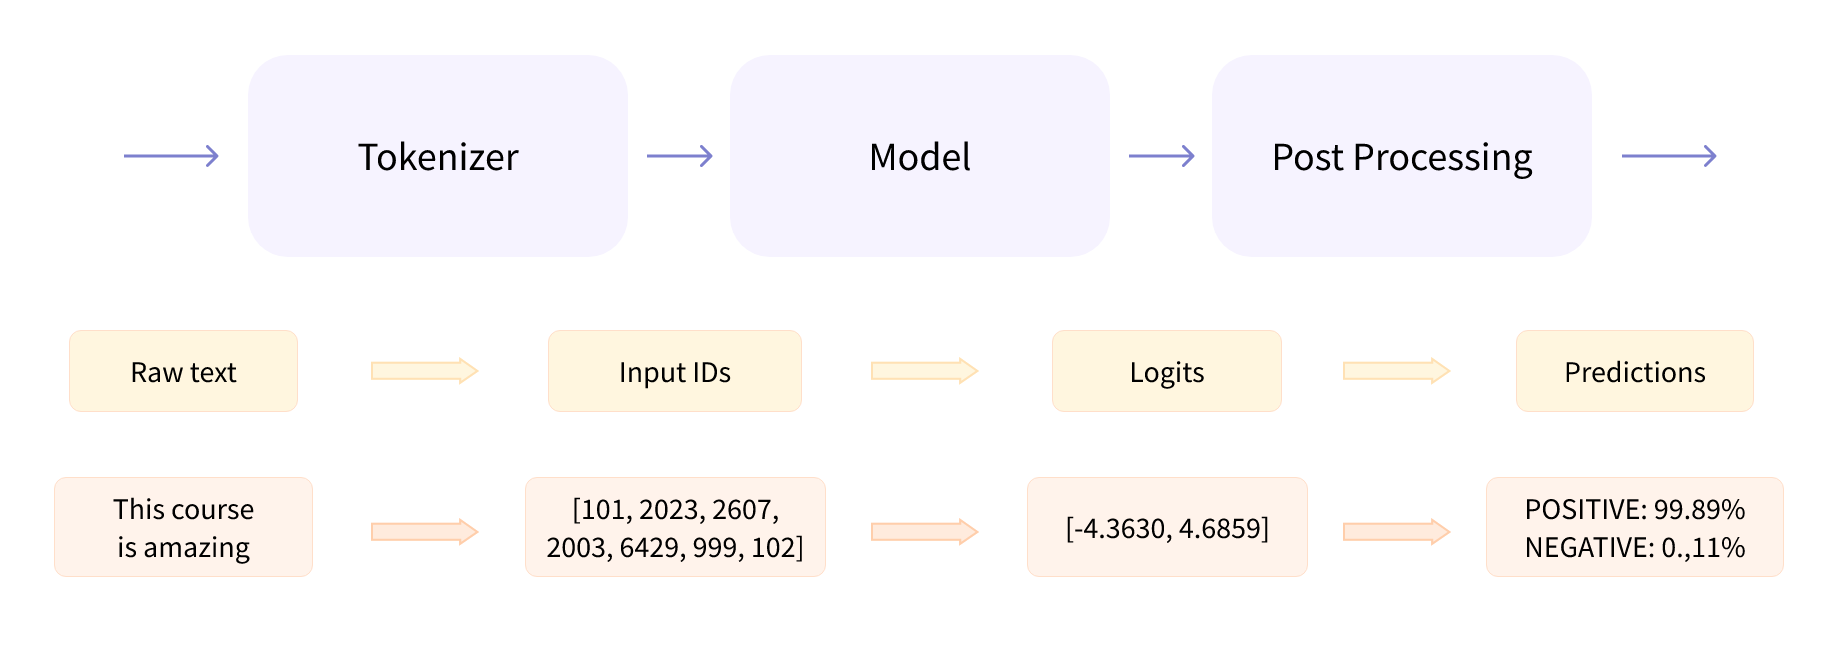

__使用分词器进行预处理：__

与其他神经网络一样， Transformer 模型无法直接处理原始文本， 因此我们管道的第一步是将文本输入转换为模型能够理解的数字。 为此，我们使用 tokenizer(标记器) ，负责：

* 将输入拆分为单词、子单词或符号（如标点符号），称为标记(token)

* 将每个标记(token)映射到一个整数

* 添加可能对模型有用的其他输入

所有这些预处理都需要以与模型预训练时完全相同的方式完成，因此我们首先需要从Model Hub中下载这些信息。为此，我们使用AutoTokenizer类及其from_pretrained()方法。使用我们模型的检查点名称，它将自动获取与模型的标记器相关联的数据，并对其进行缓存（因此只有在您第一次运行下面的代码时才会下载）。

因为 sentiment-analysis（情绪分析）管道的默认检查点是distilbert-base-uncased-finetuned-sst-2-english（你可以看到它的模型卡[here](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english))，我们运行以下程序：

In [15]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

一旦我们有了标记器，我们就可以直接将我们的句子传递给它，然后我们就会得到一本字典，它可以提供给我们的模型！剩下要做的唯一一件事就是将输入ID列表转换为张量。

您可以使用🤗 Transformers，而不必担心哪个ML框架被用作后端；它可能是PyTorch或TensorFlow，或Flax。但是，Transformers型号只接受张量作为输入。如果这是你第一次听说张量，你可以把它们想象成NumPy数组。NumPy数组可以是标量（0D）、向量（1D）、矩阵（2D）或具有更多维度。它实际上是张量；其他ML框架的张量行为类似，通常与NumPy数组一样易于实例化。

要指定要返回的张量类型（PyTorch、TensorFlow或plain NumPy），我们使用return_tensors参数：

In [16]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


现在不要担心填充和截断；我们稍后会解释这些。这里要记住的主要事情是，您可以传递一个句子或一组句子，还可以指定要返回的张量类型（如果没有传递类型，您将得到一组列表）。

以上是PyTorch张量的结果。

输出本身是一个包含两个键的字典，input_ids和attention_mask。input_ids包含两行整数（每个句子一行），它们是每个句子中标记的唯一标记（token）。我们将在本章后面解释什么是attention_mask。

__浏览模型:__

我们可以像使用标记器一样下载预训练模型。🤗 Transformers提供了一个AutoModel类，该类还具有from_pretrained()方法：

In [30]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english" ## 文本分类模型
model = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
# model

在这个代码片段中，我们下载了之前在管道中使用的相同检查点（它实际上应该已经被缓存），并用它实例化了一个模型。

这个架构只包含基本转换器模块：给定一些输入，它输出我们将调用的内容隐藏状态（hidden states），亦称特征（features）。对于每个模型输入，我们将检索一个高维向量，表示Transformer模型对该输入的上下文理解。

__高维向量？__

Transformers模块的矢量输出通常较大。它通常有三个维度：

* Batch size: 一次处理的序列数（在我们的示例中为2）。

* Sequence length: 序列的数值表示的长度（在我们的示例中为16）。   

* Hidden size: 每个模型输入的向量维度。

由于最后一个值，它被称为“高维”。隐藏的大小可能非常大（768通常用于较小的型号，而在较大的型号中，这可能达到3072或更大）。

如果我们将预处理的输入输入到模型中，我们可以看到这一点：

In [32]:
outputs = model(**inputs) ## 传递字典参数
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


In [34]:
# print(outputs.logits.shape)

注意🤗 Transformers 模型的输出与 namedtuple 或 词典 相似。您可以通过属性（就像我们所做的那样）或键（输出["last_hidden_state"]）访问元素，甚至可以通过索引访问元素，前提是您确切知道要查找的内容在哪里（outputs[0]）。

__模型头：数字的意义__

模型头将隐藏状态的高维向量作为输入，并将其投影到不同的维度。它们通常由一个或几个线性层组成：

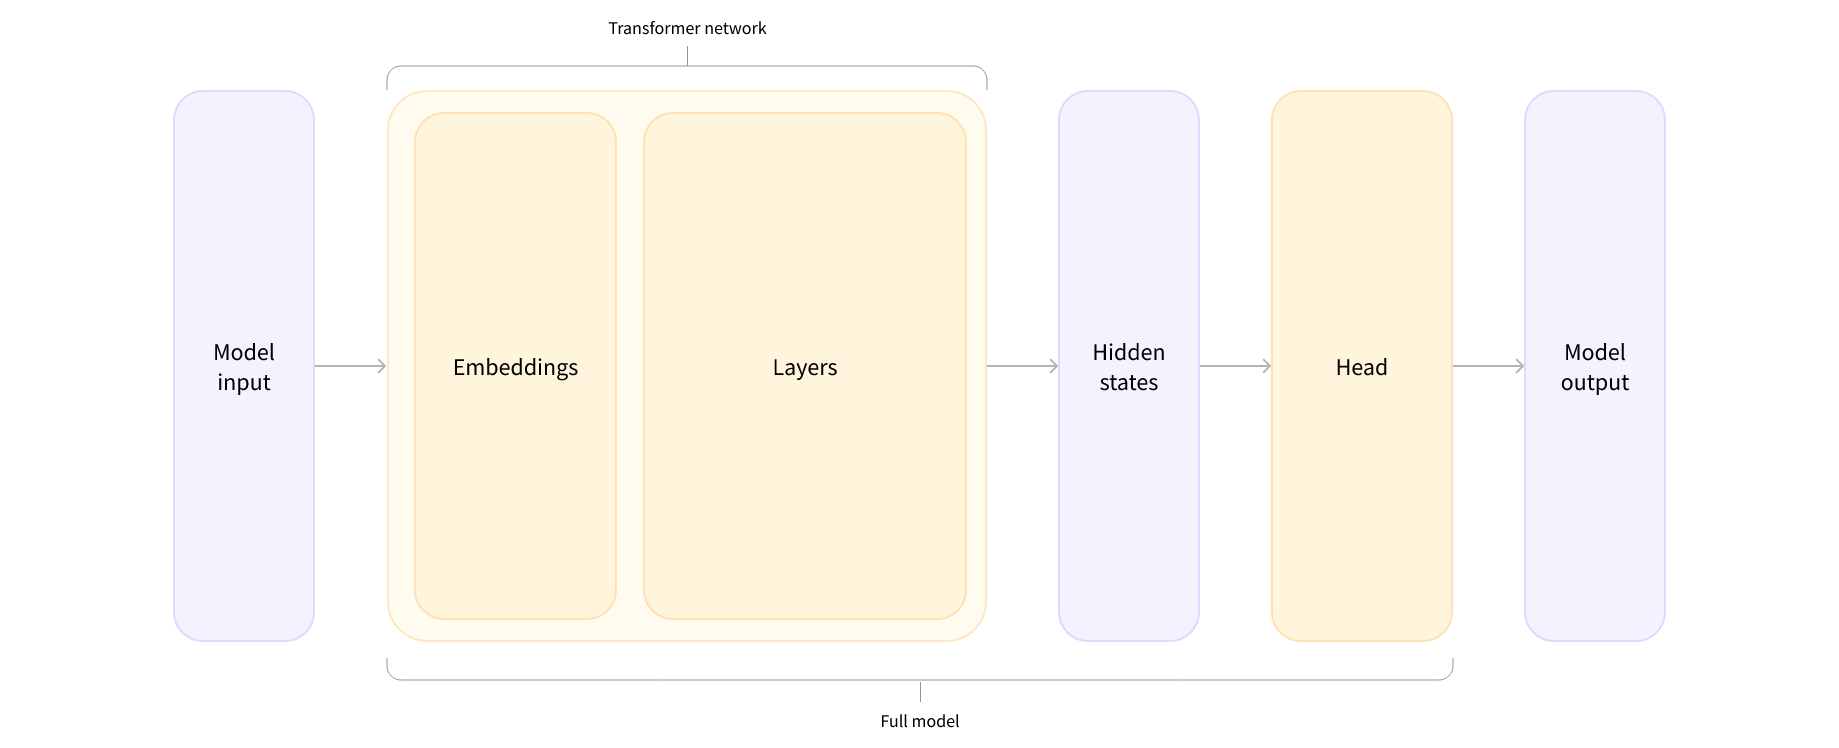

Transformers模型的输出直接发送到模型头进行处理。

在此图中，模型由其嵌入层和后续层表示。嵌入层将标记化输入中的每个输入ID转换为表示关联标记(token)的向量。后续层使用注意机制操纵这些向量，以生成句子的最终表示。

🤗 Transformers中有许多不同的体系结构，每种体系结构都是围绕处理特定任务而设计的。以下是一个非详尽的列表：

* *Model (retrieve the hidden states)

* *ForCausalLM

* *ForMaskedLM

* *ForMultipleChoice

* *ForQuestionAnswering

* *ForSequenceClassification

* *ForTokenClassification

以及其他 🤗

对于我们的示例，我们需要一个带有__序列分类头的模型__（能够将句子分类为肯定或否定）。__因此，我们实际上不会使用AutoModel类，而是使用AutoModelForSequenceClassification：__

In [23]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

__AutoModelForSequenceClassification__ 是一个可以根据预训练模型类型自动选择相应模型进行微调（fine-tuning）的类。它是基于 AutoModel 类的封装，通过添加一个针对序列分类的`头部`（ classification head ），实现对序列分类任务的处理。

在使用 __AutoModelForSequenceClassification__ 时，只需指定预训练模型的名称（例如"bert-base-uncased"）以及目标类别数，即可自动加载相应的预训练模型，并在其之上添加一个分类头部，用于根据输入序列对其进行分类。最后可以通过微调来优化该模型，以在给定的分类任务上获得更好的性能。

__AutoModel 和 AutoModelForSequenceClassification 都是用来读取预训练模型的类，但是其主要区别在于：__

* AutoModel只加载预训练模型的权重，不包括分类头层；

* AutoModelForSequenceClassification除了加载预训练模型的权重外，还包括一个针对特定任务的分类头层。

因此，使用哪个类来读取模型取决于具体任务。如果要在读取预训练模型的基础上，进一步针对某个具体的分类任务进行微调，就需要使用AutoModelForSequenceClassification来加载模型，并且需要设置分类任务的相关参数。

以自然语言文本分类为例，AutoModel适用于在预训练模型的基础上进行自定义的下游任务，比如自然语言生成、机器翻译等；而AutoModelForSequenceClassification适用于对自然语言文本进行分类的任务，比如情感分析、垃圾邮件过滤等。

因此，在选择读取预训练模型的类时，应该根据具体的应用场景和任务需求进行选择。

现在，如果我们观察输入的形状，维度将低得多：模型头将我们之前看到的高维向量作为输入，并输出包含两个值的向量（每个标签一个）：

In [ ]:
print(outputs.logits.shape) ## 加入头之后，现在具备了 logits 方法，可以看 logits 分数

因为我们只有两个句子和两个标签，所以我们从模型中得到的结果是2 x 2的形状。

__对输出进行后处理:__

我们从模型中得到的输出值本身并不一定有意义。我们来看看,


In [26]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


我们的模型预测第一句为[-1.5607, 1.6123]，第二句为[ 4.1692, -3.3464]。这些不是概率，而是logits，即模型最后一层输出的原始非标准化分数。要转换为概率，它们需要经过SoftMax层（所有🤗Transformers模型输出logits，因为用于训练的损耗函数通常会将最后的激活函数（如SoftMax）与实际损耗函数（如交叉熵）融合）：

In [27]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


现在我们可以看到，模型预测第一句为[0.0402, 0.9598]，第二句为[0.9995, 0.0005]。这些是可识别的概率分数。

为了获得每个位置对应的标签，我们可以检查模型配置的 id2label 属性（下一节将对此进行详细介绍）：

In [28]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

现在我们可以得出结论，该模型预测了以下几点：

* 第一句：否定：0.0402，肯定：0.9598

* 第二句：否定：0.9995，肯定：0.0005

我们已经成功地复制了管道的三个步骤：使用标记化器进行预处理、通过模型传递输入以及后处理！现在，让我们花一些时间深入了解这些步骤中的每一步。

-------------------------------------------------------------

* __零样本分类:__

In [2]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")
classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'sequence': 'This is a course about the Transformers library',
 'labels': ['education', 'business', 'politics'],
 'scores': [0.844599723815918, 0.11197370290756226, 0.04342665150761604]}

* __文本生成:__

In [3]:
from transformers import pipeline

generator = pipeline("text-generation")
generator("In this course, we will teach you how to")

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1202: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  "You have modified the pretrained model configuration to control generation. This is a"
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1292: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


[{'generated_text': 'In this course, we will teach you how to use an innovative software architecture to store data in a variety of databases, applications, and cloud services. Topics:\n\nData Access\n\nIntroduction to data storage and storage technologies\n\nInformation retrieval\n'}]

* __在pipeline中使用 Hub 中的其他模型：__

In [5]:
from transformers import pipeline

generator = pipeline("text-generation", model="distilgpt2")
generator(
    "In this course, we will teach you how to",
    max_length=30,
    num_return_sequences=2,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'In this course, we will teach you how to write for the world, how to write something that has no effect on your self-esteem, and'},
 {'generated_text': 'In this course, we will teach you how to get in a position to receive help with our first lesson of a major project or project. Our students'}]

In [8]:
from transformers import pipeline

unmasker = pipeline("fill-mask") ### 此任务的想法是填充给定文本中的空白
unmasker("This course will teach you all about <mask> models.", top_k=2)

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'score': 0.19619803130626678,
  'token': 30412,
  'token_str': ' mathematical',
  'sequence': 'This course will teach you all about mathematical models.'},
 {'score': 0.04052726924419403,
  'token': 38163,
  'token_str': ' computational',
  'sequence': 'This course will teach you all about computational models.'}]

* __命名实体识别:__

In [10]:
from transformers import pipeline
ner = pipeline("ner", grouped_entities=True) 
ner("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


/opt/conda/lib/python3.7/site-packages/transformers/pipelines/token_classification.py:158: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  "`grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to"


[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796019,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

* __问答系统:__

In [12]:
from transformers import pipeline
question_answerer = pipeline("question-answering") 
question_answerer( question="Where do I work?", context="My name is Sylvain and I work at Hugging Face in Brooklyn", )

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.6949759125709534, 'start': 33, 'end': 45, 'answer': 'Hugging Face'}

* __文本摘要:__

In [13]:
from transformers import pipeline

summarizer = pipeline("summarization")
summarizer(
    """
    America has changed dramatically during recent years. Not only has the number of 
    graduates in traditional engineering disciplines such as mechanical, civil, 
    electrical, chemical, and aeronautical engineering declined, but in most of 
    the premier American universities engineering curricula now concentrate on 
    and encourage largely the study of engineering science. As a result, there 
    are declining offerings in engineering subjects dealing with infrastructure, 
    the environment, and related issues, and greater concentration on high 
    technology subjects, largely supporting increasingly complex scientific 
    developments. While the latter is important, it should not be at the expense 
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other 
    industrial countries in Europe and Asia, continue to encourage and advance 
    the teaching of engineering. Both China and India, respectively, graduate 
    six and eight times as many traditional engineers as does the United States. 
    Other industrial countries at minimum maintain their output, while America 
    suffers an increasingly serious decline in the number of engineering graduates 
    and a lack of well-educated engineers.
"""
)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'summary_text': ' America has changed dramatically during recent years . The number of engineering graduates in the U.S. has declined in traditional engineering disciplines such as mechanical, civil,    electrical, chemical, and aeronautical engineering . Rapidly developing economies such as China and India continue to encourage and advance the teaching of engineering .'}]

* __翻译：__

In [ ]:
from transformers import pipeline

translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")
translator("Ce cours est produit par Hugging Face.")

## __二、模型:__

在本节中，我们将更详细地了解如何创建和使用模型。我们将使用 AutoModel类，当您希望从检查点实例化任何模型时，这非常方便。

这个AutoModel类及其所有相关项实际上是对库中各种可用模型的简单包装。它是一个聪明的包装器，因为它可以自动猜测检查点的适当模型体系结构，然后用该体系结构实例化模型。

但是，如果您知道要使用的模型类型，则可以使用直接定义其体系结构的类。让我们看看这是如何与BERT模型一起工作的。

In [35]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()

# Building the model from the config
model = BertModel(config)

配置包含许多用于构建模型的属性：

In [36]:
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



虽然您还没有看到所有这些属性都做了什么，但您应该认识到其中的一些属性：hiddensize属性定义了hidden状态向量的大小，num_hidden_layers定义了Transformer模型的层数。

__不同的加载方式__

从默认配置创建模型会使用随机值对其进行初始化：

In [ ]:
from transformers import BertConfig, BertModel

config = BertConfig()
model = BertModel(config)

# Model is randomly initialized!

该模型可以在这种状态下使用，但会输出胡言乱语；首先需要对其进行训练。我们可以根据手头的任务从头开始训练模型，为了避免不必要的重复工作，可以重用已经训练过的模型。

加载已经训练过的Transformers模型很简单-我们可以使用from_pretrained() 方法：

In [37]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


正如您之前看到的，我们可以用等效的AutoModel类替换Bert模型。从现在开始，我们将这样做，因为这会产生检查点不可知的代码；如果您的代码适用于一个检查点，那么它应该与另一个检查点无缝地工作。即使体系结构不同，这也适用，只要检查点是针对类似任务（例如，情绪分析任务）训练的。

在上面的代码示例中，我们没有使用BertConfig，而是通过Bert base cased标识符加载了一个预训练模型。这是一个模型检查点，由BERT的作者自己训练；您可以在 [model card](https://huggingface.co/bert-base-cased) 中找到更多细节.

该模型现在使用检查点的所有权重进行初始化。它可以直接用于对训练过的任务进行推理，也可以对新任务进行微调。通过预先训练重量而不是从头开始的训练，我们可以很快取得好的效果。

权重已下载并缓存在缓存文件夹中（因此将来对from_pretrained()方法的调用将不会重新下载它们）默认为 ~/.cache/huggingface/transformers . 您可以通过设置 HF_HOME 环境变量来自定义缓存文件夹。

用于加载模型的标识符可以是模型中心Hub上任何模型的标识符，只要它与BERT体系结构兼容。可以找到可用的BERT检查点的完整列表 [here ](https://huggingface.co/models?filter=bert).

In [38]:
model.save_pretrained("directory_on_my_computer")

这会将两个文件保存到磁盘： config.json pytorch_model.bin

如果你看一下 config.json 文件，您将识别构建模型体系结构所需的属性。该文件还包含一些元数据，例如检查点的来源以及上次保存检查点时使用的🤗 Transformers版本。

这个 pytorch_model.bin 文件就是众所周知的state dictionary; 它包含模型的所有权重。这两个文件齐头并进；配置是了解模型体系结构所必需的，而模型权重是模型的参数。

__使用Transformers模型进行推理:__

既然您知道了如何加载和保存模型，那么让我们尝试使用它进行一些预测。Transformer模型只能处理数字——分词器生成的数字。但在我们讨论标记化器之前，让我们先探讨模型接受哪些输入。

标记化器可以将输入转换为适当的框架张量，但为了帮助您了解发生了什么，我们将快速了解在将输入发送到模型之前必须做什么。

假设我们有几个序列：

In [47]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", trust_remote_code=True)
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [40]:
sequences = ["Hello!", "Cool.", "Nice!"]

分词器将这些转换为词汇表索引，通常称为 input IDs . 每个序列现在都是一个数字列表！结果是：

In [51]:
for i in sequences:
    print(tokenizer.encode(i))

[101, 8667, 106, 102]
[101, 13297, 119, 102]
[101, 8835, 106, 102]


In [52]:
encoded_sequences = [
    [101, 7592, 999, 102],
    [101, 4658, 1012, 102],
    [101, 3835, 999, 102],
]

这是一个编码序列列表：一个列表列表。张量只接受矩形（想想矩阵）。此“数组”已为矩形，因此将其转换为张量很容易：

In [55]:
import torch

model_inputs = torch.tensor(encoded_sequences)
model_inputs

tensor([[ 101, 7592,  999,  102],
        [ 101, 4658, 1012,  102],
        [ 101, 3835,  999,  102]])

__使用张量作为模型的输入:__

在模型中使用张量非常简单-我们只需将输入称为模型：

In [ ]:
output = model(model_inputs)

虽然模型接受许多不同的参数，但只需要 input IDs。我们稍后将解释其他参数的作用以及何时需要它们，但首先我们需要更仔细地了解 Transformer模型可以理解的输入的标记

### __三、标记器（Tokenizer）__

标记器(Tokenizer)是 NLP 管道的核心组件之一。它们有一个目的：将文本转换为模型可以处理的数据。模型只能处理数字，因此标记器(Tokenizer)需要将我们的文本输入转换为数字数据。在本节中，我们将确切地探讨标记化管道中发生的事情。

在 NLP 任务中，通常处理的数据是原始文本。这是此类文本的示例

    Jim Henson was a puppeteer
    
但是，模型只能处理数字，因此我们需要找到一种将原始文本转换为数字的方法。这就是标记器（tokenizer）所做的，并且有很多方法可以解决这个问题。目标是找到最有意义的表示——即对模型最有意义的表示——并且如果可能的话，找到最小的表示。

让我们看一下标记化算法的一些示例，并尝试回答您可能对标记化提出的一些问题。

__基于词的(Word-based):__

想到的第一种标记器是基于词的(word-based).它通常很容易设置和使用，只需几条规则，并且通常会产生不错的结果。例如，在下图中，目标是将原始文本拆分为单词并为每个单词找到一个数字表示：

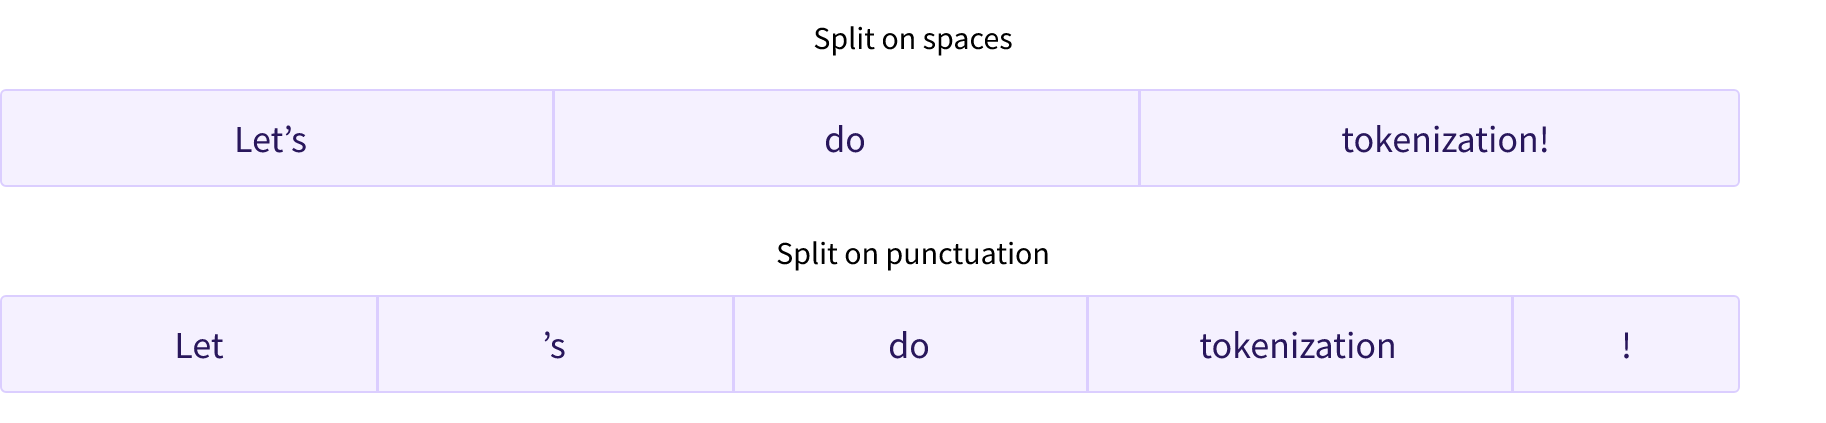

有多种方法可以拆分文本。例如，我们可以通过应用Python的split()函数，使用空格将文本标记为单词：

In [57]:
tokenized_text = "Jim Henson was a puppeteer".split()
print(tokenized_text)

['Jim', 'Henson', 'was', 'a', 'puppeteer']


还有一些单词标记器的变体，它们具有额外的标点符号规则。使用这种标记器，我们最终可以得到一些非常大的“词汇表”，其中词汇表由我们在语料库中拥有的独立标记的总数定义。

每个单词都分配了一个 ID，从 0 开始一直到词汇表的大小。该模型使用这些 ID 来识别每个单词。

<font color = '#EC7063'>如果我们想用基于单词的标记器(tokenizer)完全覆盖一种语言，我们需要为语言中的每个单词都有一个标识符，这将生成大量的标记。例如，英语中有超过 500,000 个单词，因此要构建从每个单词到输入 ID 的映射，我们需要跟踪这么多 ID。此外，像“dog”这样的词与“dogs”这样的词的表示方式不同，模型最初无法知道“dog”和“dogs”是相似的：它会将这两个词识别为不相关。这同样适用于其他相似的词，例如“run”和“running”，模型最初不会认为它们是相似的。</font>

最后，我们需要一个自定义标记(token)来表示不在我们词汇表中的单词。这被称为“未知”标记(token)，通常表示为“[UNK]”或”“。如果你看到标记器产生了很多这样的标记，这通常是一个不好的迹象，因为它无法检索到一个词的合理表示，并且你会在这个过程中丢失信息。制作词汇表时的目标是以这样一种方式进行，即标记器将尽可能少的单词标记为未知标记。

减少未知标记数量的一种方法是使用更深一层的标记器(tokenizer)，即基于字符的(character-based)标记器(tokenizer)。

__基于字符(Character-based)__

基于字符的标记器(tokenizer)将文本拆分为字符，而不是单词。这有两个主要好处：

* 词汇量要小得多。

* 词汇外（未知）标记(token)要少得多，因为每个单词都可以从字符构建。

但是这里也出现了一些关于空格和标点符号的问题：

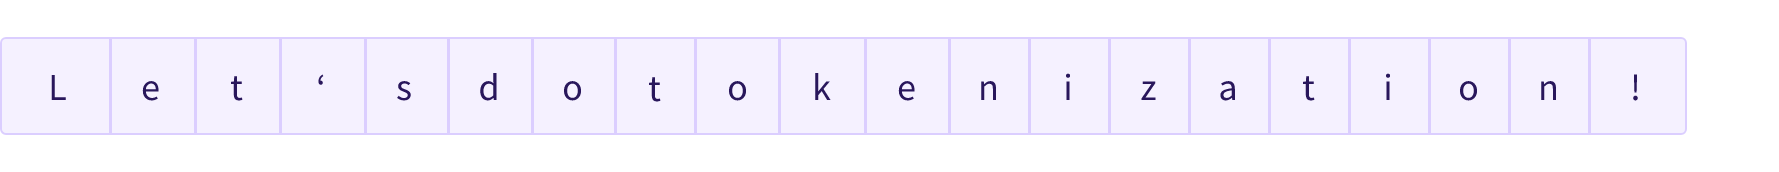

这种方法也不是完美的。由于现在表示是基于字符而不是单词，因此人们可能会争辩说，从直觉上讲，它的意义不大：每个字符本身并没有多大意义，而单词就是这种情况。然而，这又因语言而异；例如，在中文中，每个字符比拉丁语言中的字符包含更多的信息。

另一件要考虑的事情是，我们的模型最终会处理大量的词符(token)：虽然使用基于单词的标记器(tokenizer)，单词只会是单个标记，但当转换为字符时，它很容易变成 10 个或更多的词符(token)。

为了两全其美，我们可以使用结合这两种方法的第三种技术：<font color = '#EC7063'>子词标记化(subword tokenization)。</font>

__子词标记化__

子词分词算法依赖于这样一个原则，即不应将常用词拆分为更小的子词，而应将稀有词分解为有意义的子词。

例如，“annoyingly”可能被认为是一个罕见的词，可以分解为“annoying”和“ly”。这两者都可能作为独立的子词出现得更频繁，同时“annoyingly”的含义由“annoying”和“ly”的复合含义保持。

这是一个示例，展示了子词标记化算法如何标记序列“Let’s do tokenization!”：

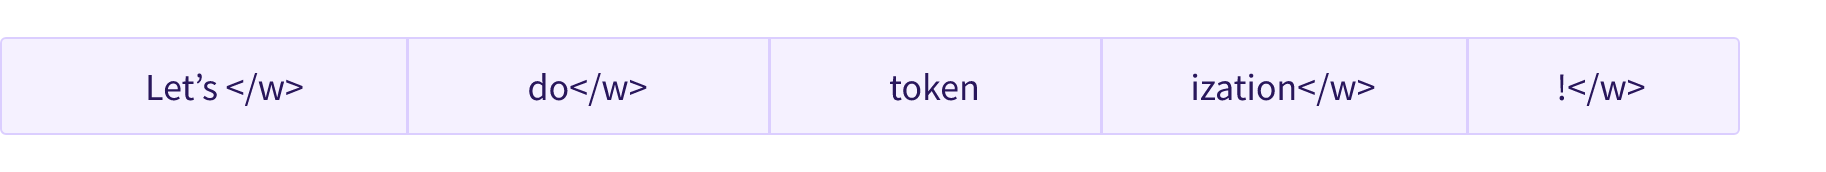

这些子词最终提供了很多语义含义：例如，在上面的示例中，“tokenization”被拆分为“token”和“ization”，这两个具有语义意义同时节省空间的词符(token)（只需要两个标记(token)代表一个长词）。这使我们能够对较小的词汇表进行相对较好的覆盖，并且几乎没有未知的标记

这种方法在 土耳其语等粘着型语言(agglutinative languages) 中特别有用，您可以通过将子词串在一起来形成（几乎）任意长的复杂词。

__还有更多！__

不出所料，还有更多的技术。仅举几例：

* Byte-level BPE, 用于 GPT-2

* WordPiece, 用于 BERT

* SentencePiece or Unigram, 用于多个多语言模型

您现在应该对标记器(tokenizers)的工作原理有足够的了解，以便开始使用 API。

__加载和保存__

加载和保存标记器(tokenizer)就像使用模型一样简单。实际上，它基于相同的两种方法： from_pretrained() 和 save_pretrained() 。这些方法将加载或保存标记器(tokenizer)使用的算法（有点像建筑学(architecture)的模型）以及它的词汇（有点像权重(weights)模型）。

加载使用与 BERT 相同的检查点训练的 BERT 标记器(tokenizer)与加载模型的方式相同，除了我们使用 BertTokenizer 类：

In [61]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

如同 AutoModel，AutoTokenizer 类将根据检查点名称在库中获取正确的标记器(tokenizer)类，并且可以直接与任何检查点一起使用：

In [60]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

我们现在可以使用标记器(tokenizer)，如上一节所示：

In [62]:
tokenizer("Using a Transformer network is simple")

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

__编码__

将文本翻译成数字被称为编码(encoding).编码分两步完成：标记化，然后转换为输入 ID。

正如我们所见，第一步是将文本拆分为单词（或单词的一部分、标点符号等），通常称为标记(token)。有多个规则可以管理该过程，这就是为什么我们需要使用模型名称来实例化标记器(tokenizer)，以确保我们使用模型预训练时使用的相同规则。

第二步是将这些标记转换为数字，这样我们就可以用它们构建一个张量并将它们提供给模型。为此，标记器(tokenizer)有一个词汇(vocabulary)，这是我们在实例化它时下载的部分 from_pretrained() 方法。同样，我们需要使用模型预训练时使用的相同词汇。

为了更好地理解这两个步骤，我们将分别探讨它们。请注意，我们将使用一些单独执行部分标记化管道的方法来向您展示这些步骤的中间结果，但实际上，您应该直接在您的输入上调用标记器(tokenizer)（如第 2 部分所示）。

__标记化__

标记化过程由标记器(tokenizer)的tokenize() 方法实现：

In [63]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']


此方法的输出是一个字符串列表或标记(token).这个标记器(tokenizer)是一个子词标记器(tokenizer)：它对词进行拆分，直到获得可以用其词汇表表示的标记(token)。transformer 就是这种情况，它分为两个标记：transform 和 ##er。

__从词符(token)到输入 ID__

输入 ID 的转换由标记器(tokenizer)的`convert_tokens_to_ids()`方法实现：

In [65]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[7993, 170, 13809, 23763, 2443, 1110, 3014]


__解码__

解码(Decoding) 正好相反：从词汇索引中，我们想要得到一个字符串。这可以通过 decode() 方法实现，如下：

In [66]:
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

Using a transformer network is simple


请注意， decode 方法不仅将索引转换回标记(token)，还将属于相同单词的标记(token)组合在一起以生成可读的句子。当我们使用预测新文本的模型（根据提示生成的文本，或序列到序列问题（如翻译或摘要））时，这种行为将非常有用。

到现在为止，您应该了解标记器(tokenizer)可以处理的原子操作：标记化、转换为 ID 以及将 ID 转换回字符串。然而，我们只是刮到了冰山一角。在下一节中，我们将采用我们的方法来克服它的限制，并看看如何克服它们。

### __四、处理多个序列__

在上一节中，我们探讨了最简单的用例：对一个小长度的序列进行推理。然而，一些问题已经出现：

* 我们如何处理多个序列？

* 我们如何处理多个序列不同长度?

* 词汇索引是让模型正常工作的唯一输入吗？

* 是否存在序列太长的问题？

让我们看看这些问题会带来什么样的问题，以及如何使用🤗 Transformers API解决它们

__模型需要一批输入__

在上一个练习中，您看到了序列如何转换为数字列表。让我们将此数字列表转换为张量，并将其发送到模型：

In [68]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(ids)
# This line will fail.
model(input_ids)

RuntimeError: The size of tensor a (14) must match the size of tensor b (512) at non-singleton dimension 1

不！为什么失败了？我们遵循了第2节中管道的步骤。

问题是我们向模型发送了一个序列，而🤗 `Transformers模型默认情况下需要多个句子`。在这里，当我们将分词器应用于一个应用程序时，我们尝试在幕后完成分词器所做的一切，但如果仔细观察，您会发现它不仅将输入ID列表转换为张量，还在其顶部添加了一个维度：

In [72]:
input_ids

tensor([ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
         2026,  2878,  2166,  1012])

In [71]:
tokenized_inputs = tokenizer(sequence, return_tensors="pt") 
print(tokenized_inputs["input_ids"])

tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102]])


`input_ids 和 tokenized_inputs["input_ids"] 数据不一致的原因：`


tokenizer.tokenize(sequence) 和 tokenizer.convert_tokens_to_ids(tokens) 只是将一个字符串转换成了一个列表形式的 tokens 和其对应的 ids，但是还没有对它们进行对齐和添加特殊 token，例如 [CLS] 和 [SEP]。而 tokenizer(sequence, return_tensors="pt") 中的 return_tensors="pt" 表示返回 PyTorch tensor 格式的结果，并且 tokenizer 会在 sequence 前后添加特殊 token，同时还会根据模型的最大输入长度对 sequence 进行截断或者填充。因此，两者返回的结果是不一致的。

具体来说，tokenizer(sequence, return_tensors="pt") 返回的是一个字典类型的数据，其中包括三个 keys：input_ids、token_type_ids 和 attention_mask，分别对应着添加特殊 token 后的 token ids、token type ids 和 attention mask。而 tokenizer.tokenize(sequence) 返回的是一个列表形式的 tokens，需要再通过 tokenizer.convert_tokens_to_ids(tokens) 将其转换成对应的 ids。

让我们重试并添加一个新维度：

In [73]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor([ids])
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


Batching 是一次通过模型发送多个句子的行为。如果你只有一句话，你可以用一个序列构建一个批次：

In [76]:
batched_ids = [ids, ids]
# batched_ids

批处理允许模型在输入多个句子时工作。使用多个序列就像使用单个序列构建批一样简单。不过，还有第二个问题。`当你试图将两个（或更多）句子组合在一起时，它们的长度可能不同。如果您以前使用过张量，那么您知道它们必须是矩形，因此无法将输入ID列表直接转换为张量。`为了解决这个问题，我们通常填充输入。

__填充输入__

以下列表不能转换为张量：

In [82]:
batched_ids = [
    [200, 200, 200],
    [200, 200]
]

# print(model(torch.tensor(batched_ids)).logits) ### ValueError: expected sequence of length 3 at dim 1 (got 2)

为了解决这个问题，我们将使用填充使张量具有矩形。Padding通过在值较少的句子中添加一个名为Padding token的特殊单词来确保我们所有的句子长度相同。例如，如果你有10个包含10个单词的句子和1个包含20个单词的句子，填充将确保所有句子都包含20个单词。在我们的示例中，生成的张量如下所示：

In [78]:
padding_id = 100

batched_ids = [
    [200, 200, 200],
    [200, 200, padding_id],
]

可以在tokenizer.pad_token_id中找到填充令牌ID. 让我们使用它，将我们的两句话分别发送到模型中，并分批发送到一起：

In [80]:
tokenizer.pad_token_id

0

In [79]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(model(torch.tensor(batched_ids)).logits)

tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


<font color = '#EC7063'>我们批处理预测中的logits有点问题：第二行应该与第二句的logits相同，但我们得到了完全不同的值！

这是因为Transformer模型的关键特性是关注层，它将每个标记上下文化。这些将考虑填充标记，因为它们涉及序列中的所有标记。为了在通过模型传递不同长度的单个句子时，或者在传递一批应用了相同句子和填充的句子时获得相同的结果，我们需要告诉这些注意层忽略填充标记。这是通过使用 attention mask来实现的。

__注意力掩码__

Attention masks是与输入ID张量形状完全相同的张量，用0和1填充：1s表示应注意相应的标记，0s表示不应注意相应的标记（即，模型的注意力层应忽略它们）。

让我们用attention mask完成上一个示例：

In [83]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


现在我们得到了该批中第二个句子的相同登录。请注意，第二个序列的最后一个值是一个填充ID，它在attention mask中是一个0值。

<font color = '#EC7063'>在Attention机制中，Attention mask的0和1通常表示：

* 0表示该位置不应该被Attention到（被忽略）。

* 1表示该位置应该被Attention到（被保留）。

例如，对于一个输入序列中的某个位置，如果它是一个填充（padding）的位置，那么在Attention计算时通常需要将其忽略，因此在Attention mask中就会将该位置对应的值设置为0。而对于输入序列中的其他有效位置，就会将对应的值设置为1，表示在Attention计算中需要将其考虑在内。这样，Attention mask可以帮助模型忽略填充位置的影响，更准确地计算有效位置之间的注意力权重。

__长序列__

对于Transformers模型，我们可以通过模型的序列长度是有限的。大多数模型处理多达512或1024个令牌的序列，当要求处理更长的序列时，会崩溃。此问题有两种解决方案：

* 使用支持的序列长度较长的模型。

* 截断序列。

模型有不同的支持序列长度，有些模型专门处理很长的序列。 [Longformer](https://huggingface.co/transformers/model_doc/longformer.html) 这是一个例子，另一个是 [LED](https://huggingface.co/transformers/model_doc/led.html) . 如果您正在处理一项需要很长序列的任务，我们建议您查看这些模型。

否则，我们建议您通过指定max_sequence_length参数：


In [ ]:
sequence = sequence[:max_sequence_length]

### __五、结合使用__

Transformers API可以通过一个高级函数为我们处理所有这些，我们将在这里深入讨论。当你直接在句子上调用标记器时，你会得到准备通过模型传递的输入

In [87]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
model_inputs

{'input_ids': [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

这里，model_inputs 变量包含模型良好运行所需的一切。对于DistilBERT，它包括输入 ID和注意力掩码(attention mask)。其他接受额外输入的模型也会有标记器对象的输出。

正如我们将在下面的一些示例中看到的，这种方法非常强大。首先，它可以标记单个序列：

In [86]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
model_inputs

{'input_ids': [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

它还一次处理多个序列，并且API没有任何变化：

In [88]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

model_inputs = tokenizer(sequences)
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

它可以根据几个目标进行 __填充：__ 

In [93]:
print("sequences: ",sequences)
print()

# Will pad the sequences up to the maximum sequence length
model_inputs = tokenizer(sequences, padding="longest")
print(model_inputs)
print()

"""按照最长的句子来 pad ，并且可以看到被 pad 的 token 后面的 attention_mask 都是0，表示不被关注"""

# Will pad the sequences up to the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, padding="max_length")
print(model_inputs)
print()

# Will pad the sequences up to the specified max length
model_inputs = tokenizer(sequences, padding="max_length", max_length=8)
print(model_inputs)


sequences:  ["I've been waiting for a HuggingFace course my whole life.", 'So have I!']

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

它还可以 __截断序列:__ 

In [95]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Will truncate the sequences that are longer than the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, truncation=True)
print(model_inputs)
print()

# Will truncate the sequences that are longer than the specified max length
model_inputs = tokenizer(sequences, max_length=8, truncation=True)
print(model_inputs)
print()


{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 102], [101, 2061, 2031, 1045, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}



标记器对象可以处理到特定框架张量的转换，然后可以直接发送到模型。例如，在下面的代码示例中，我们提示标记器从不同的框架返回张量——"pt"返回PyTorch张量，"tf"返回TensorFlow张量，"np"返回NumPy数组：

In [96]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Returns PyTorch tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")
print(model_inputs)
print()

# Returns TensorFlow tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="tf")
print(model_inputs)
print()

# Returns NumPy arrays
model_inputs = tokenizer(sequences, padding=True, return_tensors="np")
print(model_inputs)
print()


{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  2061,  2031,  1045,   999,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

{'input_ids': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662,
        12172,  2607,  2026,  2878,  2166,  1012,   102],
       [  101,  2061,  2031,  1045,   999,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}

{'input_ids': array([[  101,  1045,  1005,  2310,  204

__特殊词符(token)__

如果我们看一下标记器返回的输入 ID，我们会发现它们与之前的略有不同：

In [100]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
print('model_inputs["input_ids"]: ',model_inputs["input_ids"])

tokens = tokenizer.tokenize(sequence)
print("tokens: ",tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print("ids: ",ids)

model_inputs["input_ids"]:  [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102]
tokens:  ['i', "'", 've', 'been', 'waiting', 'for', 'a', 'hugging', '##face', 'course', 'my', 'whole', 'life', '.']
ids:  [1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012]


一个在开始时添加了一个标记(token) ID，一个在结束时添加了一个标记(token) ID。让我们解码上面的两个ID序列，看看这是怎么回事

In [99]:
print(tokenizer.decode(model_inputs["input_ids"]))
print(tokenizer.decode(ids))

[CLS] i've been waiting for a huggingface course my whole life. [SEP]
i've been waiting for a huggingface course my whole life.


<font color = '#EC7063'>标记器在开头添加了特殊单词[CLS]，在结尾添加了特殊单词[SEP]。这是因为模型是用这些数据预训练的，所以为了得到相同的推理结果，我们还需要添加它们。请注意，有些模型不添加特殊单词，或者添加不同的单词；模型也可能只在开头或结尾添加这些特殊单词。在任何情况下，标记器都知道需要哪些词符，并将为您处理这些词符。

__结束：从标记器到模型__

现在我们已经看到了标记器对象在应用于文本时使用的所有单独步骤，让我们最后一次看看它如何处理多个序列（填充！），非常长的序列（截断！），以及多种类型的张量及其主要API：

In [102]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [-3.6183,  3.9137]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [103]:
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[0.9507, 0.0493],
        [0.7297, 0.2703]], grad_fn=<SoftmaxBackward0>)


In [104]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}